# Toy Data Solution

In [1]:
import numpy as np
#import pandas as pd
import torch
import torch.nn
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve

def reseed(seed=96):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

# 1.1 Generating synthetic data

Make function `generate_toydata()` that recieves:
* `batch_size` - number of datapoints
* `w` - multipliyer of linear function
* `b` - offset of linear function

and returns two vectors:
* `X` of shape (batch_size, 2) containing 2D datapoints
* `Y` if shape (batch_size,) containing targets.

This function generates random batch size number of 2D points $(x_1, x_2)$ where:
* $x_1$ are random numbers and
* $x_2$ are random numbers multiplied by $w$ and to which $b$ is added.

Target ($y$) of $(x_1, x_2)$ will be:
* $1$ if $x_2 > w * x_1 + b$
* else $0$



In [2]:
def generate_toy_data(batch_size, w, b):
    x1 = torch.rand(batch_size)
    x2 = torch.rand(batch_size) * w + b
    assert x1.shape == x2.shape == (batch_size, )
    
    x_data = torch.stack((x1, x2)).T
    assert x_data.shape == (batch_size, 2)
    
    y_target = (x2 > w * x1 + b).float()
    assert y_target.shape == (batch_size, )
    
    return x_data, y_target
    

x_data, y_truth = generate_toy_data(10, w=5, b=3)
x_data, y_truth

(tensor([[0.7208, 4.8421],
         [0.3851, 7.4120],
         [0.4733, 6.5889],
         [0.8840, 3.9616],
         [0.9268, 6.6549],
         [0.9257, 6.7162],
         [0.2436, 3.6903],
         [0.9238, 3.2003],
         [0.1431, 4.6544],
         [0.2761, 6.3447]]),
 tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 1.]))

In [3]:
reseed(1337)
temp = generate_toy_data(4, w=2, b=1)
assert isinstance(temp, tuple) and len(temp) == 2
assert torch.allclose(temp[0], torch.tensor([[0.0783, 1.4008], [0.4956, 1.0573], [0.6231, 2.1702], [0.4224, 2.3934]]), atol=1e-4)
assert torch.equal(temp[1], torch.tensor([1., 0., 0., 1.]))
del temp


# 1.2 Plotting data

Create function `plot_toy_data()` which receives two vectors:
* $X$ vector of n datapoints $(x_1, x_2)$
* $Y$ vector of n targets

This function plots 2D datapoints in blue if corresponding target value is 1, red if opposite.

Generate 1000 synthetic data points where $w$ = 5 and $b$ = 3.

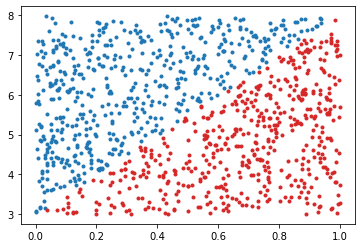

In [4]:
def plot_toy_data(x_data, y_truth, perceptron=None):
    blue = []
    orange = []
    black_blue = []
    black_orange = []
    if perceptron:
        y_pred = perceptron(x_data).squeeze().detach()
        y_pred = (y_pred > 0.5).float()
    else:
        y_pred = y_truth

    for x_i, y_true_i, y_pred_i in zip(x_data, y_truth, y_pred):
        
        is_black = y_true_i != y_pred_i

        if y_true_i == 1.:
            if is_black:
                black_blue.append(x_i)
            else:
                blue.append(x_i)
        else:
            if is_black:
                black_orange.append(x_i)
            else:
                orange.append(x_i)
    
    if blue:
        blue = np.stack(blue)
        plt.scatter(blue[:,0], blue[:,1], marker=".", c="tab:blue")
    
    if orange:
        orange = np.stack(orange)
        plt.scatter(orange[:,0], orange[:,1], marker=".", c="tab:red")

    if perceptron:
        if black_blue:
            black_blue = np.stack(black_blue)
            plt.scatter(black_blue[:,0], black_blue[:,1], marker=".", c="black")
        if black_orange:
            black_orange = np.stack(black_orange)
            plt.scatter(black_orange[:,0], black_orange[:,1], marker=".", c="black")

        # hyperplane
        xx = np.linspace(x_data[:,0].min(), x_data[:,0].max(), 30)
        yy = np.linspace(x_data[:,1].min(), x_data[:,1].max(), 30)
        xv, yv = np.meshgrid(xx, yy)
        xy = np.vstack([xv.ravel(), yv.ravel()]).T
        z = perceptron(torch.tensor(xy, dtype=torch.float)).detach().numpy().reshape(yv.shape)
        
        plt.contour(xx, yy, z, colors='k', linestyles=["--", "-", "--"], levels=[0.4, 0.5, 0.6])
    plt.show()

plot_toy_data(*generate_toy_data(1024, w=5, b=3))
# plot_toy_data(*get_toy_data(1024), perceptron)


# 2.1. Perceptron

Create `Perceptron` class where perceptron receives 2 numbers and outputs 1 number.  
Create `forward()` method which receives datapoint $(x_1, x_2)$ which is an input to perceptron and applies sigmoid on perceptron's output.  
Create `predict()`method which receives datapoint $(x_1, x_2)$ and returns 1 if the result after forward is greater or equal 0.5, otherwise 0.  
Create `reset()` method which resets parameters of the model (call `reset_parameter` on model layer)

In [5]:
class Perceptron(torch.nn.Module):

    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc1 = torch.nn.Linear(2, 1)

    def forward(self, x_in):
        return torch.sigmoid(self.fc1(x_in)).squeeze()
    
    def predict(self, x_in):
        return (self.forward(x_in) >= 0.5).float()
    
    def reset(self):
        self.fc1.reset_parameters()

x = torch.FloatTensor([[1, 2], [3, 4]])
#x = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32)
perceptron = Perceptron()
perceptron(x)

perceptron.predict(torch.FloatTensor([3,4]))

tensor(1.)

In [6]:
reseed(1337)
temp = Perceptron()
assert hasattr(temp, "forward") and hasattr(temp, "predict") and hasattr(temp, "reset")
assert torch.allclose(temp(torch.FloatTensor([1, 2])), torch.tensor(0.3930), atol=1e-4)
assert torch.allclose(temp(torch.FloatTensor([[1, 2], [3, 4]])), torch.tensor([0.3930, 0.1625]), atol=1e-4)
assert torch.equal(temp.predict(torch.FloatTensor([1, 2])), torch.tensor(0.))
assert torch.equal(temp.predict(torch.FloatTensor([[1, 2], [-5, 4]])), torch.tensor([0., 1.]))

temp.reset()
W, b = temp.parameters()
assert torch.allclose(W, torch.tensor([-0.1097, -0.4237]), atol=1e-4) and torch.allclose(b, torch.tensor([-0.6666]), atol=1e-4)

del temp, W, b

Set following variables:
* learning rate `lr` to 0.01
* `batch_size` = 1000
* `w` = 90
* `b` = 6

Instantiate:
* `model` as perceptron, 
* `optimizer`as adam optimizer with defined learning rate, 
* `loss_fn` as binary cross-entropy loss, 

Generate and remember static toy data with predefined parameters into `x_data_static` and `y_truth_static`.
Plot toy data

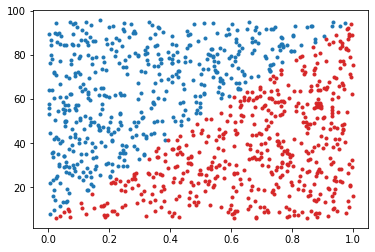

In [7]:
lr = 0.01
batch_size = 1000
W = 90
B = 6

model = Perceptron()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
loss_fn = torch.nn.BCELoss()

x_data_static, y_truth_static = generate_toy_data(batch_size, w=W, b=B)
plot_toy_data(x_data_static, y_truth_static)

In [8]:
assert isinstance(model, Perceptron)
assert isinstance(optimizer, torch.optim.Adam)
assert optimizer.defaults["lr"] == 0.01

assert isinstance(loss_fn, torch.nn.BCELoss)

assert isinstance(x_data_static, torch.Tensor)
assert x_data_static.shape == (1000, 2)

assert isinstance(x_data_static, torch.Tensor)
assert y_truth_static.shape == (1000,)


# 2.2 Train

Set following variables:
* `n_epochs` to 100  - number of epochs
* `n_batches` to 10 - number of batches
* `epoch` to 0 - current epoch number

**Train procedure**

for each epoch  
then for each batch:
* make forward step, 
* make backward step,
* append to `losses` current loss  

at the end of batch loop increment `epoch`.

..........
epoch: 1 loss: 2.75
..........
epoch: 2 loss: 0.773
..........
epoch: 3 loss: 1.07
..........
epoch: 4 loss: 0.703
..........
epoch: 5 loss: 0.726
..........
epoch: 6 loss: 0.687
..........
epoch: 7 loss: 0.66
..........
epoch: 8 loss: 0.649
..........
epoch: 9 loss: 0.625
..........
epoch: 10 loss: 0.615
..........
epoch: 11 loss: 0.595
..........
epoch: 12 loss: 0.58
..........
epoch: 13 loss: 0.576
..........
epoch: 14 loss: 0.566
..........
epoch: 15 loss: 0.546
..........
epoch: 16 loss: 0.526
..........
epoch: 17 loss: 0.519
..........
epoch: 18 loss: 0.526
..........
epoch: 19 loss: 0.499
..........
epoch: 20 loss: 0.499
..........
epoch: 21 loss: 0.489
..........
epoch: 22 loss: 0.474
..........
epoch: 23 loss: 0.463
..........
epoch: 24 loss: 0.467
..........
epoch: 25 loss: 0.45
..........
epoch: 26 loss: 0.44
..........
epoch: 27 loss: 0.436
..........
epoch: 28 loss: 0.425
..........
epoch: 29 loss: 0.422
..........
epoch: 30 loss: 0.418
..........
epoch: 31 loss

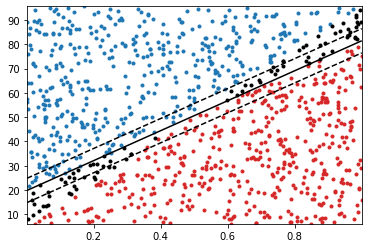

In [9]:
batch_size = 1000
n_epochs = 100
n_batches = 10
epoch = 0

losses = []

model.reset()
for epoch in range(n_epochs):
    for _ in range(n_batches):
        model.train()
        
        x, y = generate_toy_data(batch_size, w=W, b=B)
        yhat = model(x)
        
        loss = loss_fn(yhat, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())
        print(".", end="")
    epoch += 1
    print(f"\nepoch: {epoch} loss: {loss:0.3}\r")     

plot_toy_data(x_data_static, y_truth_static, model)

Plot losses

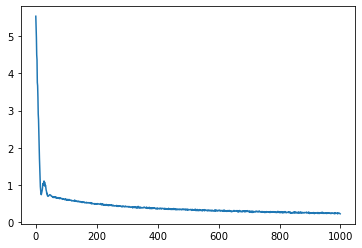

In [10]:
plt.plot(range(len(losses)), losses)

# 2.3 Evaluate

Evaluate model on static data. calculate accuracy, precission, recall and f1. Printout confusion matrix.

Note: You can use `scikitlearn.metrics`

In [11]:
y_pred = model.predict(x_data_static)

#y_pred = perceptron(x_data_static).squeeze()

acc = accuracy_score(y_truth_static, y_pred)
p = precision_score(y_truth_static, y_pred)
r = recall_score(y_truth_static, y_pred)
f1 = f1_score(y_truth_static, y_pred)

print(f"acc: {acc:.3f}", )
print(f"p: {p:.3f}", )
print(f"r: {r:.3f}", )
print(f"f1: {f1:.3f}\n")

[[tn, fp], [fn, tp]] = confusion_matrix(y_truth_static, y_pred)
print(f"tn: {tn}  fp: {fp}")
print(f"fn: {fn}  tp: {tp}")

acc: 0.916
p: 0.909
r: 0.920
f1: 0.915

tn: 465  fp: 45
fn: 39  tp: 451


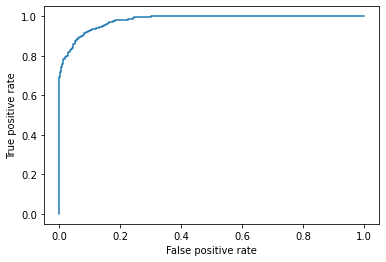

In [12]:
fpr, tpr, th1 = roc_curve(y_truth_static, model(x_data_static).detach().clone().numpy())

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(fpr, tpr)

# 2.4. Interspect

Determine learnt weights and compare them to `W` and `B` parameters used for generating toy data.

In [13]:
ins, outs = model.parameters()
w1, w2 = ins.detach().clone().numpy()[0]
b = outs.detach().clone().numpy()[0]

print((w1, w2), b)

(-5.009944, 0.08114193) -1.6024367


In [14]:
w = -w1/w2
b = -b/w2

print(f"model parameters: {w:.2f} {b:.2f}")
print(f"toy data generator parameters: {W:.2f} {B:.2f}")

model parameters: 61.74 19.75
toy data generator parameters: 90.00 6.00


**model**

$ x_1 * w_1 + x_2 * w_2 + b = 0 $  
$ x_2 * w_2 = - x_1 * w_1 - b $  
$ x_2 = - \frac{w_1}{w_2} x_1 - \frac{b}{w_2} $  

**data**

$ x_2 = W * x_1 + B $
